# Produção de arte com técnicas de transfer learning

### Importação de bibliotecas

Algumas funções utilizadas no código são de uma versão mais antiga do tensorflow, e é preciso desabilitar a execução do eager (saiba mais [aqui](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)) para o funcionamento do código.

❗IMPORTANTE: ao rodar a primeira célula, é preciso clicar em `Restart Runtime` e não rodá-la novamente após reinicializar o ambiente.

In [ ]:
!pip install tensorflow==1.13.2
!pip install q keras==2.0.8

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
from __future__ import print_function

import time
import numpy as np
import pandas as pd

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b
from PIL import Image

### Imagens de entrada

As imagens de entrada terão dimensão 256x256 pixels

Você pode substituir pelas imagens que você quiser testar! Basta fazer o upload das imagens aqui no Google Colab e trocar os valores das variáveis `content_image_path` e `style_image_path`. Vale ressaltar que essas imagens devem ser do tipo `.jpg`

#### Imagem de conteúdo

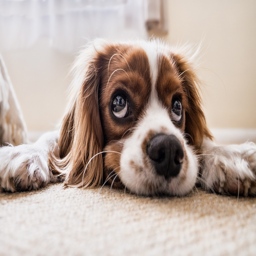

In [ ]:
height = 256
width = 256

content_image_path ='dog.jpg'
content_image = Image.open(content_image_path)  
content_image = content_image.resize((width, height))
content_image

#### Imagem de estilo

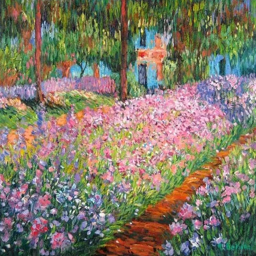

In [ ]:
style_image_path = 'claude_monet.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

### Conversão das imagens

Para algumas operações que serão realizadas futuramente, como a concatenação de um tensor a essas imagens, é necessário transformá-las em um array numpy e adicionar uma dimensão extra

In [ ]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(f"Tamanho da imagem de conteúdo = {content_array.shape}")

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(f"Tamanho da imagem de estilo = {style_array.shape}")

Tamanho da imagem de conteúdo = (1, 256, 256, 3)
Tamanho da imagem de estilo = (1, 256, 256, 3)


### Pré-processamento das imagens

Como será utilizada a técnica de transfer learning, com o modelo VGG-16, é necessário realizar um pré-processamento básico nas imagens. Assim, é necessário subtrair em todos os canais RGB valores médio pré-calculados na competição Imaginet.

Isso é feito para centralizar a intensidade das imagens em zero, melhorando a precisão e a velocidade de treinamento.

Ao final, ainda é necessário converter os valores RGB para BGR, para ficarem adequados para a utilização do modelo pré-treinado VGG-16.

In [ ]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

### Criação dos tensores

Em seguida, é necessário converter as imagens em tensores, utilizando o Keras backend. Assim, há um tensor para a imagem de conteúdo, para a imagem de estilo, e para a imagem final a ser gerada pelo modelo.

Esses tensores devem ser criados para gerar um tensor de entrada que possa ser aplicado no nosso modelo.

In [ ]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

input_tensor = backend.concatenate([content_image, style_image, combination_image], axis=0)

In [ ]:
print('Conferindo as dimensões dos tensores')
print(f'Imagem de conteúdo: {content_image.shape}')
print(f'Imagem de estilo: {style_image.shape}')
print(f'Imagem combinada: {combination_image.shape}')
print(f'Tensor de entrada: {input_tensor.shape}')

Conferindo as dimensões dos tensores
Imagem de conteúdo: (1, 256, 256, 3)
Imagem de estilo: (1, 256, 256, 3)
Imagem combinada: (1, 256, 256, 3)
Tensor de entrada: (3, 256, 256, 3)


### Implementando o transfer learning

O VGG-16 é um modelo pré-treinado com 16 camadas, sendo um classificador para redes convolucionais, trabalhando muito bem com imagens. Assim, ele é capaz de codificar características perceptivas de imagens.

Porém, o VGG-16 é um classificador, e essa classificação é feita em suas últimas camadas, no estágio Fully Connected de uma rede convolucional. Como isso não será preciso para a geração das imagens, essa camada pode ser retirada do modelo.

In [ ]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_9': <tf.Tensor 'concat_8:0' shape=(3, 256, 256, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_8/Relu:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_8/Relu:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_8/MaxPool:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_8/Relu:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_8/Relu:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_8/MaxPool:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_8/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_8/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_8/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_8/MaxPool:0' shape=(3, 32, 32, 256) dtype=float32>,
 'blo

### Implementando o cálculo do erro

#### Considerações iniciais

Como vamos trabalhar com a combinação de duas imagens, é necessário calcular a perda relativa tanto para a imagem de conteúdo quanto para a imagem de estilo.

Dessa forma, primeiro é necessário atribuir pesos a cada uma das imagens, com base na influência que queremos que cada uma delas tenha na imagem final. Pode-se perceber que o peso atribuído à imagem de estilo é bem maior.

In [ ]:
content_weight = 0.050
style_weight = 10.0
total_variation_weight = 1.0

Inicialização de um tensor com zero para armazenar a perda

In [ ]:
loss = backend.variable(0.)

#### Cálculo do erro da imagem de conteúdo

O cálculo do erro da imagem de conteúdo é obtido a partir do MSE (Mean Squared Error) entre as duas variáveis. No código, isso é feito com a função `backend.square`

Vale ressaltar também que a camada `block2_conv2` foi a camada da VGG-16 escolhida para extrair os recursos da imagem de conteúdo

In [ ]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss +  content_weight * content_loss(content_image_features, combination_features)

print(f"Layer features: {layer_features}")
print(f"Combination features: {combination_features}")

Layer features: Tensor("block2_conv2_8/Relu:0", shape=(3, 128, 128, 128), dtype=float32)
Combination features: Tensor("strided_slice_229:0", shape=(128, 128, 128), dtype=float32)


#### Cálculo do erro da imagem de estilo

Nessa etapa, queremos capturar o estilo de ambas as imagens (mas lembrando que foi atribuído um maior peso à imagem de estilo). Para fazer isso, é preciso calcular a `matriz gram`, que é o produto escalar da variável de imagem de estilo com a sua transposta.

Isso é necessário justamente para trazer o foco no estilo da imagem nessa etapa, e não em seu conteúdo.

In [ ]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

Em seguida, também é utilizado o MSE para cálculo do erro na imagem de estilo, porém com algumas operações adicionais, e nesse caso, são escolhidas mais camadas de convolução da VGG-16 para extrair os recursos das imagens.

In [ ]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

#### Cálculo do erro total

In [ ]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

### Cálculo dos gradientes

Antes de chamar um otimizador para iterar e otimizar cada vez mais a imagem final, é preciso criar gradientes de perda em relação à variável de combinação. Para isso, utilizou-se a função `backend.gradients`, disponível nas primeiras versões do Tensorflow (por isso foi necessário mudar a versão da biblioteca no início do código)

In [ ]:
grads = backend.gradients(loss, combination_image)

Sempre será feita uma avaliação da perda e dos gradientes para garantir que a imagem está sendo gerada cada vez malhor. Para isso, foi criada a classe `Evaluator`, que irá retornar o valor da perda e do gradiente.

In [ ]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

### Computando a nova imagem

Para isso, será utilizada uma função da biblioteca `scipy`, a `fmin_l_bfgs_b`, responsável por minimizar uma função usando o algoritmo L-BFGS-B

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 15
t_total = 0

for i in range(iterations):
    print('Iteração', i+1)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Valor de perda', min_val)
    end_time = time.time()
    print(f'Tempo de execução da iteração: {end_time - start_time}')
    t_total += end_time - start_time

print(f"Tempo total para execução do código: {t_total}")

Iteração 1
Valor de perda 82795150000.0
Tempo de execução da iteração: 161.42140531539917
Iteração 2
Valor de perda 37877326000.0
Tempo de execução da iteração: 159.44300746917725
Iteração 3
Valor de perda 29112950000.0
Tempo de execução da iteração: 159.68870496749878
Iteração 4
Valor de perda 24520264000.0
Tempo de execução da iteração: 159.9928662776947
Iteração 5
Valor de perda 22526394000.0
Tempo de execução da iteração: 161.91243886947632
Iteração 6
Valor de perda 21396537000.0
Tempo de execução da iteração: 165.7723388671875
Iteração 7
Valor de perda 20607363000.0
Tempo de execução da iteração: 161.72891521453857
Iteração 8
Valor de perda 19907682000.0
Tempo de execução da iteração: 160.2443904876709
Iteração 9
Valor de perda 19531915000.0
Tempo de execução da iteração: 160.75899744033813
Iteração 10
Valor de perda 19229830000.0
Tempo de execução da iteração: 161.3571901321411
Iteração 11
Valor de perda 19030640000.0
Tempo de execução da iteração: 160.97230291366577
Iteração 12


### Imagem final

Aqui temos a imagem final, sendo necessário antes de mostrar a imagem, reconverter do BGR para o RGB, e somar os valores que antes foram subtraídos para garantir uma melhor performance do código.

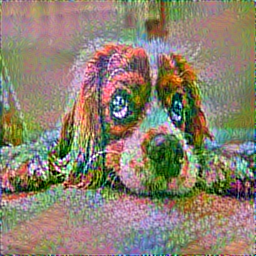

In [ ]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

### Referências

*   https://medium.datadriveninvestor.com/neural-style-transfer-ai-in-art-with-keras-and-tf2-34392aeaeb39
*   https://anand0427.github.io/style-transfer-with-keras/
*   https://www.kaggle.com/code/yildizemre/making-ai-art-with-keras/notebook



